# =============================================================
# Quantum Finance - Autenticação Facial com Detecção de Vivacidade
# =============================================================
 Notebook de Computer Vision (Google Colab)<br>
 
 Autores: <br>
RM: 358770 - Erika Koyanagui<br>
RM: 358488 - Fabio Asnis Campos da Silva<br>
RM: 359283 - Lucas Huber Pissaia <br>
RM: 358477 - Matheus Raeski<br>

 Objetivo: Prototipar um sistema de autenticação facial seguro com detecção de vivacidade.<br>
<br>

Links video apresentação: <br>

Youtube - https://youtu.be/ASXEqmySHoM <br>
Drive - https://drive.google.com/file/d/1R5rpkcUrRRBez-LhSS-X8bXrKDZfbUN6/view?usp=sharing<br>

###=============================================================
### SEÇÃO 1 - Instalação das dependências
### =============================================================

In [40]:
import cv2
import mediapipe as mp
import numpy as np

### =============================================================
### SEÇÃO 2 - Detector de Faces (Mediapipe Face Detection)
### =============================================================

I0000 00:00:1760300468.403567 41418424 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4
W0000 00:00:1760300468.446132 42915674 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Vídeo processado: 173 frames, 173 faces detectadas no total em 173 frames.


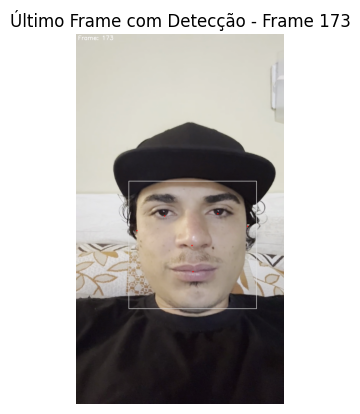

In [41]:
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

# Carregar vídeo de exemplo (substitua pelo seu arquivo)
video_path = './video_teste.mp4'  # Substitua pelo caminho do vídeo local
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Erro ao abrir vídeo. Verifique o caminho do arquivo.")
    detected_frames = []
else:
    frame_count = 0
    faces_total = 0
    detected_frames = []  # Lista de frames com detecções
    last_processed_frame = None

    with mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.5) as face_detection:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            frame_count += 1
            image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = face_detection.process(image_rgb)

            if results.detections:
                faces_total += len(results.detections)
                for detection in results.detections:
                    mp_drawing.draw_detection(frame, detection)
                detected_frames.append(frame_count)  # Armazenar número do frame
                last_processed_frame = frame.copy()  # Para exibição

        cap.release()

    print(f"Vídeo processado: {frame_count} frames, {faces_total} faces detectadas no total em {len(detected_frames)} frames.")

    # Exibir o último frame processado com detecções (opcional)
    if last_processed_frame is not None:
        # Adicionar info do frame detectado na imagem
        if detected_frames:
            frame_num = detected_frames[-1]
            cv2.putText(last_processed_frame, f'Frame: {frame_num}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        import matplotlib.pyplot as plt
        plt.imshow(cv2.cvtColor(last_processed_frame, cv2.COLOR_BGR2RGB))
        plt.title(f'Último Frame com Detecção - Frame {frame_num}')
        plt.axis('off')
        plt.show()
    else:
        print("Nenhum frame com faces foi processado.")

### =============================================================
### SEÇÃO 3 - Identificação Facial (comparação de embeddings simples)
### =============================================================
Mediapipe Face Mesh pode gerar pontos faciais únicos por pessoa — usaremos uma média desses pontos como 'assinatura facial'.

I0000 00:00:1760300486.724017 41418424 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4
W0000 00:00:1760300486.728115 42916206 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1760300486.736537 42916202 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1760300486.793494 41418424 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4
W0000 00:00:1760300486.795541 42916224 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1760300486.799438 42916224 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


✅ Cliente identificado no frame 1 (distância: 0.0842).


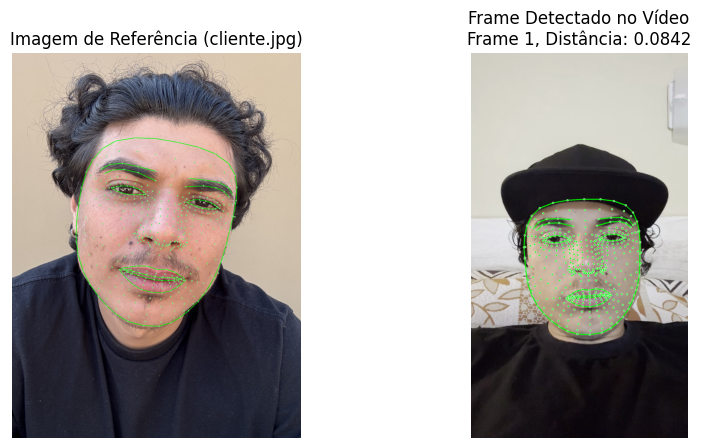

In [42]:
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils

# Função para gerar uma assinatura facial única
def gerar_assinatura(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None, None
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    with mp_face_mesh.FaceMesh(static_image_mode=True) as face_mesh:
        result = face_mesh.process(rgb)
        if not result.multi_face_landmarks:
            return None, None
        pontos = []
        for lm in result.multi_face_landmarks[0].landmark:
            pontos.append([lm.x, lm.y, lm.z])
        return np.mean(pontos, axis=0), result.multi_face_landmarks[0]  # Retornar também os landmarks

# Gerar assinatura do cliente (imagem de referência)
assinatura_cliente, landmarks_ref = gerar_assinatura('./cliente.jpg')  # Imagem de referência do cliente

if assinatura_cliente is None:
    print("Erro: Não foi possível gerar assinatura do cliente. Verifique a imagem.")
    cliente_identificado = False
else:
    # Carregar imagem de referência para exibição
    imagem_referencia = cv2.imread('./cliente.jpg')
    if imagem_referencia is not None and landmarks_ref is not None:
        # Desenhar landmarks na imagem de referência com linhas mais visíveis
        drawing_spec = mp_drawing.DrawingSpec(color=(0,255,0), thickness=3, circle_radius=2)
        mp_drawing.draw_landmarks(imagem_referencia, landmarks_ref, mp_face_mesh.FACEMESH_CONTOURS, landmark_drawing_spec=drawing_spec, connection_drawing_spec=drawing_spec)
        imagem_referencia = cv2.cvtColor(imagem_referencia, cv2.COLOR_BGR2RGB)

    # Comparar frame a frame os detectados
    video_path = './video_teste.mp4'
    cap = cv2.VideoCapture(video_path)
    cliente_identificado = False
    matched_frame_image = None
    matched_landmarks = None
    matched_frame_num = None
    distancia_identificacao = None

    if not cap.isOpened():
        print("Erro ao abrir vídeo.")
    else:
        with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1) as face_mesh:
            for frame_num in detected_frames:  # Apenas frames com detecções
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num - 1)  # Frame numbers start from 1, but pos from 0
                ret, frame = cap.read()
                if not ret:
                    continue
                rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                result = face_mesh.process(rgb)
                if result.multi_face_landmarks:
                    pontos = []
                    for lm in result.multi_face_landmarks[0].landmark:
                        pontos.append([lm.x, lm.y, lm.z])
                    assinatura_frame = np.mean(pontos, axis=0)
                    distancia = np.linalg.norm(assinatura_cliente - assinatura_frame)
                    if distancia < 0.1:
                        cliente_identificado = True
                        matched_frame_image = frame.copy()
                        matched_landmarks = result.multi_face_landmarks[0]
                        matched_frame_num = frame_num
                        distancia_identificacao = distancia
                        print(f"✅ Cliente identificado no frame {frame_num} (distância: {distancia:.4f}).")
                        break  # Para no primeiro match

        cap.release()

    if not cliente_identificado:
        print("❌ Cliente não identificado no vídeo.")
    else:
        # Desenhar landmarks no frame detectado
        if matched_landmarks is not None:
            drawing_spec = mp_drawing.DrawingSpec(color=(0,255,0), thickness=3, circle_radius=2)
            mp_drawing.draw_landmarks(matched_frame_image, matched_landmarks, mp_face_mesh.FACEMESH_CONTOURS, landmark_drawing_spec=drawing_spec, connection_drawing_spec=drawing_spec)

        # Exibir lado a lado: imagem de referência e frame detectado
        if imagem_referencia is not None and matched_frame_image is not None:
            import matplotlib.pyplot as plt
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            axes[0].imshow(imagem_referencia)
            axes[0].set_title('Imagem de Referência (cliente.jpg)')
            axes[0].axis('off')
            axes[1].imshow(cv2.cvtColor(matched_frame_image, cv2.COLOR_BGR2RGB))
            axes[1].set_title(f'Frame Detectado no Vídeo\nFrame {matched_frame_num}, Distância: {distancia_identificacao:.4f}')
            axes[1].axis('off')
            plt.show()

### =============================================================
### SEÇÃO 4 - Detecção de Vivacidade (piscadas e movimento)
### =============================================================

I0000 00:00:1760300506.234883 41418424 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4
W0000 00:00:1760300506.237026 42916779 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1760300506.246489 42916777 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Vídeo analisado: 173 frames.
✅ Piscadas detectadas (39). Vivacidade confirmada no vídeo.


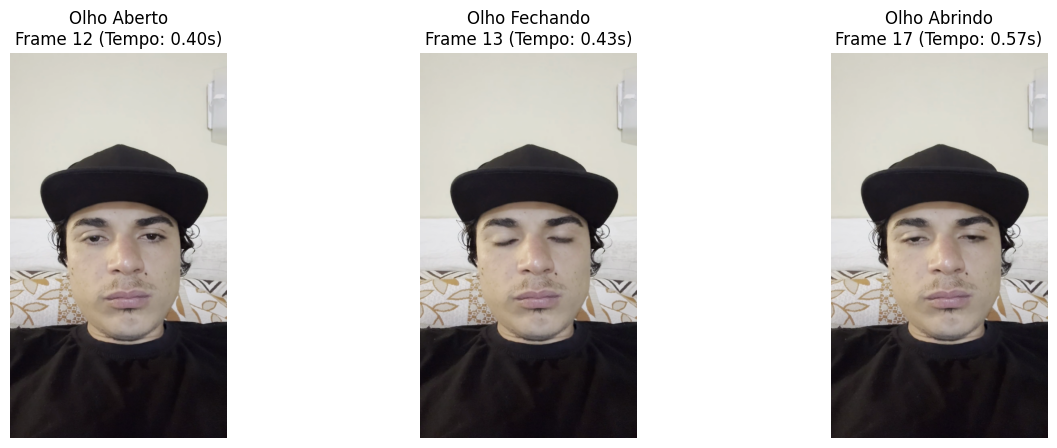

In [43]:
mp_face_mesh = mp.solutions.face_mesh

if not cliente_identificado:
    print("Cliente não identificado. Execute a Seção 3 primeiro.")
else:
    # Analisar vivacidade do vídeo inteiro (6 segundos)
    video_path = './video_teste.mp4'
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Erro ao abrir vídeo.")
    else:
        piscadas = 0
        frame_idx = 0
        fps = cap.get(cv2.CAP_PROP_FPS) or 30  # Fallback para 30 fps se não conseguir obter
        blink_sequence = None  # Dicionário para armazenar a sequência
        prev_dist = None
        prev_frame = None
        prev_idx = None

        with mp_face_mesh.FaceMesh(max_num_faces=1, refine_landmarks=True, static_image_mode=False) as face_mesh:
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break

                frame_idx += 1
                rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                result = face_mesh.process(rgb)

                if result.multi_face_landmarks:
                    for face_landmarks in result.multi_face_landmarks:
                        # Pegar landmarks dos olhos (referência oficial Mediapipe: índices 145 e 159 olho esquerdo)
                        p1 = np.array([face_landmarks.landmark[145].x, face_landmarks.landmark[145].y])
                        p2 = np.array([face_landmarks.landmark[159].x, face_landmarks.landmark[159].y])
                        dist = np.linalg.norm(p1 - p2)

                        # Lógica para detectar sequência de piscada
                        if prev_dist is not None and prev_frame is not None and prev_idx is not None:
                            if prev_dist >= 0.01 and dist < 0.01 and blink_sequence is None:  # Olho fechando (primeira vez)
                                blink_sequence = {'open': (prev_frame, prev_idx), 'closing': (frame, frame_idx), 'opening': None}
                            elif blink_sequence and blink_sequence['opening'] is None and dist >= 0.01:  # Olho abrindo após fechar
                                blink_sequence['opening'] = (frame, frame_idx)
                                break  # Capturar apenas a primeira sequência completa

                        if dist < 0.01:  # threshold para olho fechado
                            piscadas += 1

                        prev_dist = dist
                        prev_frame = frame.copy()
                        prev_idx = frame_idx

        cap.release()

        print(f"Vídeo analisado: {frame_idx} frames.")
        if piscadas > 0:
            print(f"✅ Piscadas detectadas ({piscadas}). Vivacidade confirmada no vídeo.")
            # Exibir sequência visual de piscada
            if blink_sequence and blink_sequence['opening'] is not None:
                import matplotlib.pyplot as plt
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                titles = ['Olho Aberto', 'Olho Fechando', 'Olho Abrindo']
                keys = ['open', 'closing', 'opening']
                for i, key in enumerate(keys):
                    frame, idx = blink_sequence[key]
                    time_sec = idx / fps
                    axes[i].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                    axes[i].set_title(f'{titles[i]}\nFrame {idx} (Tempo: {time_sec:.2f}s)')
                    axes[i].axis('off')
                plt.show()
            else:
                print("Sequência de piscada não capturada completamente.")
        else:
            print("❌ Nenhuma piscada detectada. Possível spoofing (vídeo estático).")